In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [21]:
# grid and parameters
nx, ny = 512, 512 # grid size
Lx, Ly = 4.0, 4.0 # physical size
dx, dy = Lx / nx, Ly / ny # grid spacing
x = np.linspace(-Lx / 2, Lx / 2, nx)
y = np.linspace(-Ly / 2, Ly / 2, ny)
X, Y = np.meshgrid(x, y)

In [22]:
# cylinder parameters
radius = 0.1
U_inf = 2.0 # free stream velocity

# velocity field
u = np.ones((ny, nx)) * U_inf # x-velocity
v = np.zeros((ny, nx)) # y-velocity

# mask for the cylinder
cylinder = (X**2 + Y**2) < radius**2

In [23]:
# time stepping parameters
dt = 0.001
nt = 500 # number of time steps
nu = 0.01 # kinematic viscosity

In [24]:
# apply boundary conditions
def apply_boundary_conditions(u, v):
    u[cylinder] = 0
    v[cylinder] = 0
    return u, v

In [25]:
# time stepping
for _ in range(nt):
    # compute derivatives
    u_x = (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / (2 * dx)
    u_y = (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / (2 * dy)
    v_x = (np.roll(v, -1, axis=1) - np.roll(v, 1, axis=1)) / (2 * dx)
    v_y = (np.roll(v, -1, axis=0) - np.roll(v, 1, axis=0)) / (2 * dy)
    
    # laplacian
    laplacian_u = (np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) + 
                   np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) - 4 * u) / (dx * dy)
    laplacian_v = (np.roll(v, 1, axis=1) + np.roll(v, -1, axis=1) + 
                   np.roll(v, 1, axis=0) + np.roll(v, -1, axis=0) - 4 * v) / (dx * dy)
    
    # update velocity field
    u_new = u + dt * (-u * u_x - v * u_y + nu * laplacian_u)
    v_new = v + dt * (-u * v_x - v * v_y + nu * laplacian_v)
    
    # boundary conditions
    u, v = apply_boundary_conditions(u_new, v_new)

In [26]:
# gaussian filter for smoothing
u_smoothed = gaussian_filter(u, sigma=1)

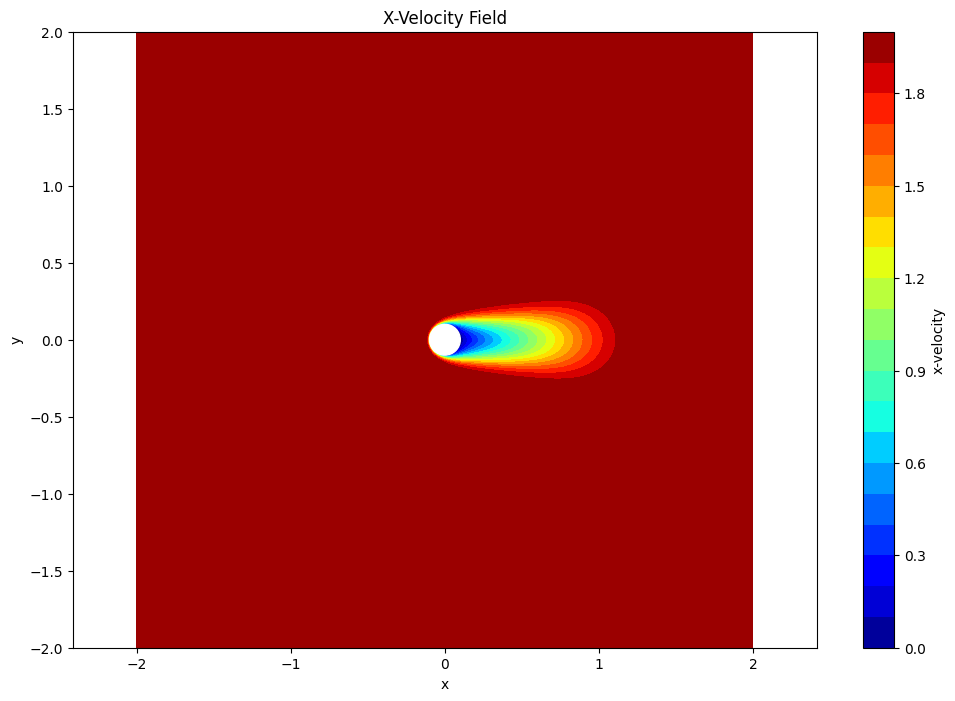

In [27]:
# plot x-velocity field
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, u_smoothed, 20, cmap='jet')
plt.colorbar(label='x-velocity')

# draw the cylinder
circle = plt.Circle((0, 0), radius, color='white', alpha=1.0)
plt.gca().add_artist(circle)
# plt.contour(X, Y, cylinder, colors='white', linewidths=0.5)

plt.title('X-Velocity Field')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()